In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

 98% 146M/149M [00:04<00:00, 42.4MB/s]
100% 149M/149M [00:04<00:00, 37.6MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/brain-tumor-mri-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Using TensorFlow's integrated Keras to import layers
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout, Input
from keras.models import Sequential, Model
from keras.layers import Conv2D, GlobalMaxPool2D
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import pandas as pd

In [ ]:
tr_df_path="/content/Training"
labels=[]
filepaths=[]

folds=os.listdir(tr_df_path)
for fold in folds:
    foldpath=os.path.join(tr_df_path,fold)
    foldlist=os.listdir(foldpath)
    for file in foldlist:
        filepath=os.path.join(foldpath,file)

        labels.append(fold)
        filepaths.append(filepath)


l=pd.Series(labels,name="labels")
f=pd.Series(filepaths,name="filepaths")

tr_df=pd.concat([f,l],axis=1)

In [ ]:
tst_df_path="/content/Testing"
labels=[]
filepaths=[]

folds=os.listdir(tst_df_path)
for fold in folds:
    foldpath=os.path.join(tst_df_path,fold)
    foldlist=os.listdir(foldpath)
    for file in foldlist:
        filepath=os.path.join(foldpath,file)

        labels.append(fold)
        filepaths.append(filepath)

l=pd.Series(labels,name="labels")
f=pd.Series(filepaths,name="filepaths")

ts_df=pd.concat([f,l],axis=1)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
valid_df,tst_df=train_test_split(ts_df,test_size=0.5,random_state=50,stratify=ts_df["labels"])
print(f"ts_df shape: {ts_df.shape}")
print("---"*10)
print(f"valid data shape: {valid_df.shape}")
print(f"test data shape: {tst_df.shape}")

ts_df shape: (1311, 2)
------------------------------
valid data shape: (655, 2)
test data shape: (656, 2)


In [ ]:
img_size=(224,224)

tr=ImageDataGenerator()
ts=ImageDataGenerator()

train_gen=tr.flow_from_dataframe(tr_df,x_col="filepaths",y_col="labels",
                                 target_size=img_size,
                                 batch_size=16,shuffle=True,
                                 class_mode='categorical',color_mode="rgb")


valid_gen=ts.flow_from_dataframe(ts_df,x_col='filepaths',y_col='labels',
                                target_size=img_size,
                                 class_mode="categorical",color_mode="rgb",
                                 shuffle=True,batch_size=16,)


test_gen=ts.flow_from_dataframe(ts_df, x_col='filepaths', y_col='labels',
                                 target_size=img_size,
                                 batch_size=16, shuffle=False,
                                 color_mode="rgb", class_mode="categorical")

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [ ]:
import numpy as np

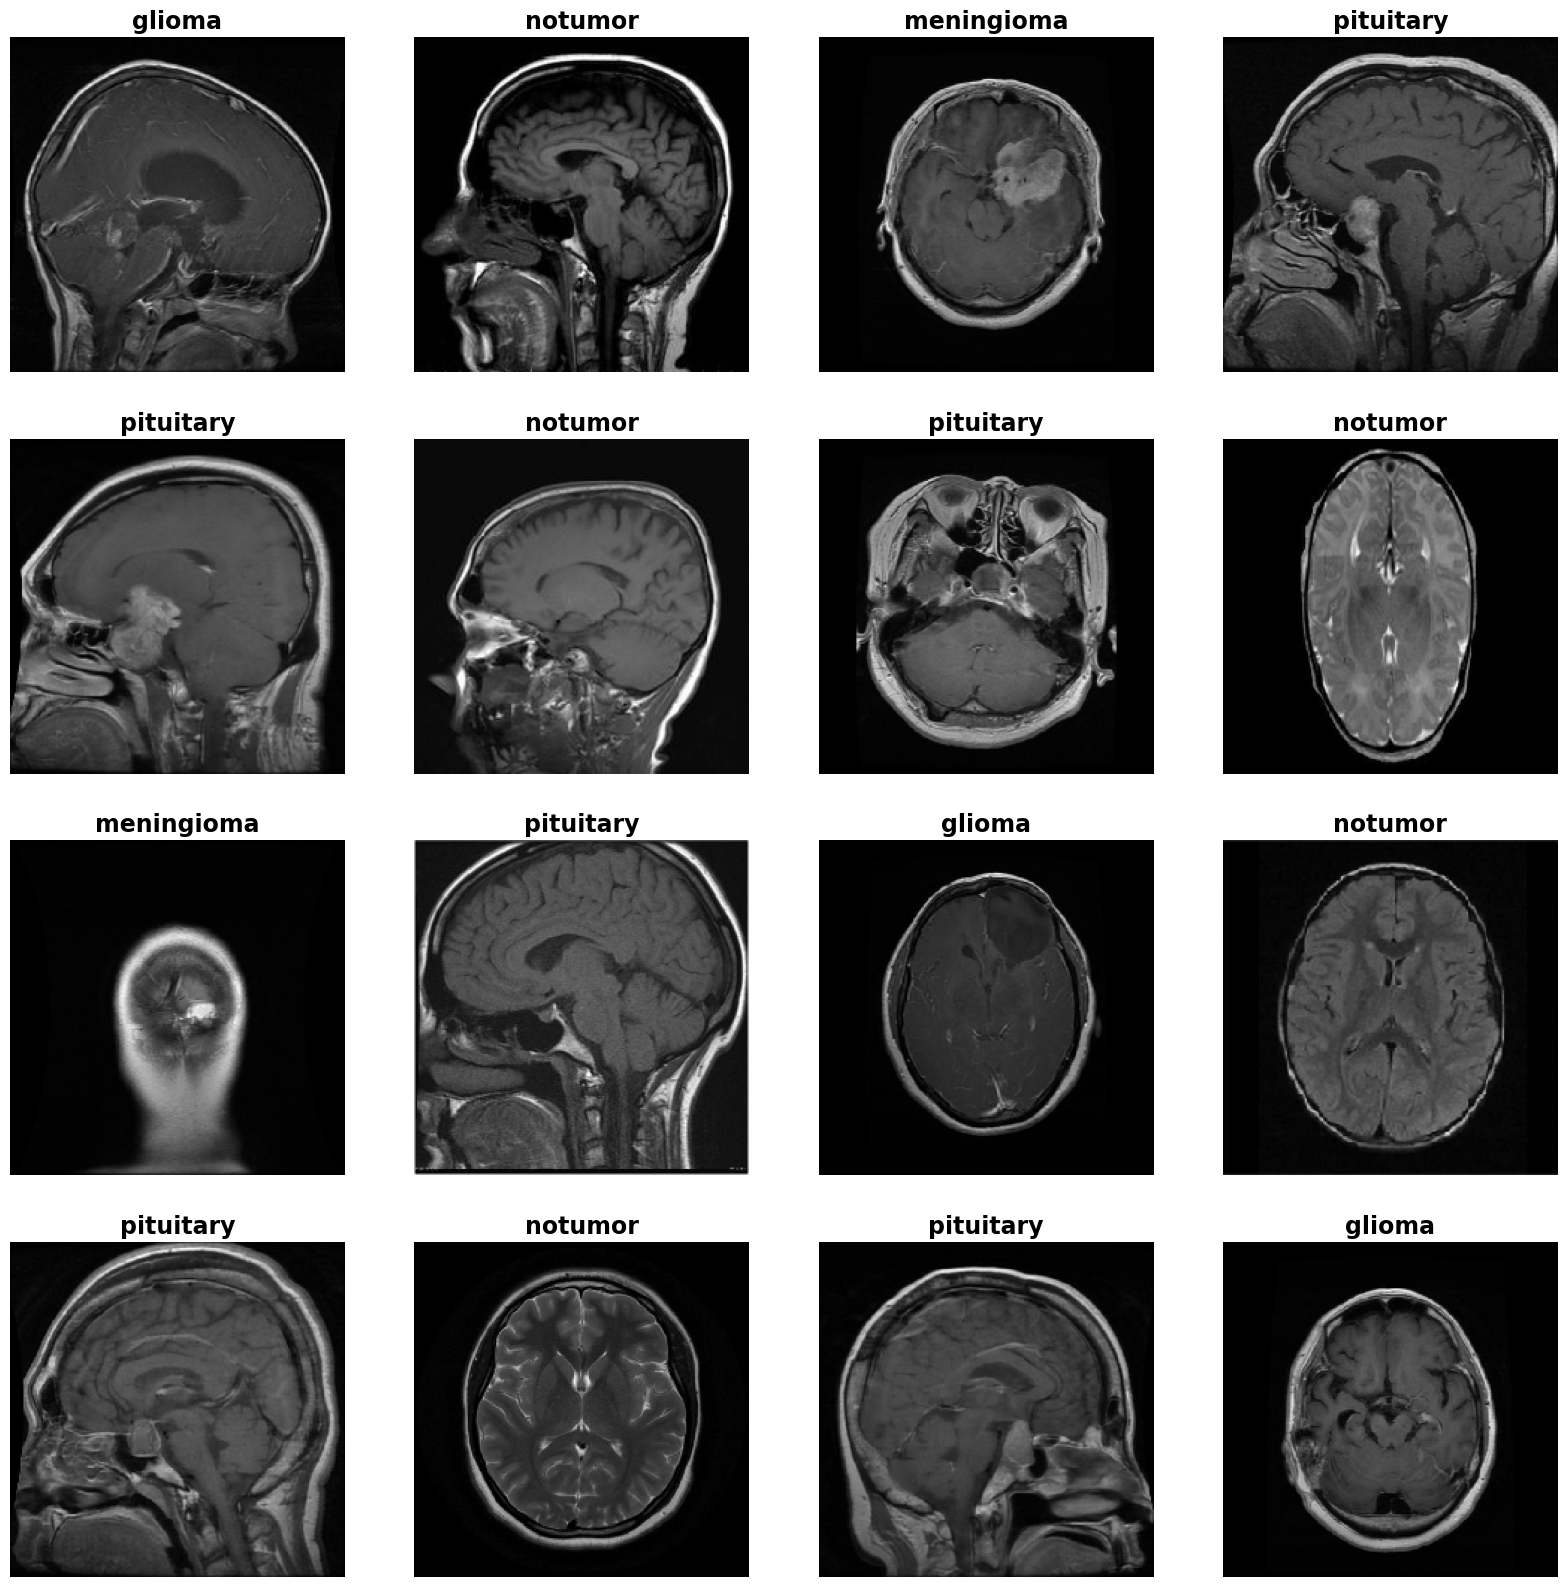

In [ ]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'black' , fontsize= 17,weight="bold")
    plt.axis('off')
plt.show()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, LSTM, Reshape, Layer
from tensorflow.keras.models import Model

In [ ]:
print("Shape of training data:", train_gen[0][0].shape)
print("Shape of training labels:", train_gen[0][1].shape)

print("Shape of validation data:", valid_gen[0][0].shape)
print("Shape of validation labels:", valid_gen[0][1].shape)

print("Shape of test data:", test_gen[0][0].shape)
print("Shape of test labels:", test_gen[0][1].shape)


Shape of training data: (16, 224, 224, 3)
Shape of training labels: (16, 4)
Shape of validation data: (16, 224, 224, 3)
Shape of validation labels: (16, 4)
Shape of test data: (16, 224, 224, 3)
Shape of test labels: (16, 4)


In [ ]:
from keras.applications import VGG16
from keras.layers import Input, Flatten, Dense, Dropout, Reshape, LSTM, GRU


In [ ]:
# Load the pre-trained VGG16 model without the fully connected layers
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the VGG16 model
for layer in vgg_model.layers:
    layer.trainable = False

# Flatten the output of VGG16
flatten_output = Flatten()(vgg_model.output)

dense1 = Dense(256, activation='relu')(flatten_output)
dropout1 = Dropout(0.5)(dense1)
reshape_output = Reshape((1, -1))(dropout1)
lstm_output = LSTM(128, return_sequences=True)(reshape_output)
gru_output = GRU(64)(lstm_output)
output = Dense(4, activation='softmax')(gru_output)

encoder_decoder_model = Model(inputs=vgg_model.input, outputs=output)

encoder_decoder_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
encoder_decoder_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [ ]:
train_steps_per_epoch = len(train_gen)
valid_steps_per_epoch = len(valid_gen)

# Define the number of epochs
num_epochs = 10

In [ ]:
# Train the model
history = encoder_decoder_model.fit(
    train_gen,
    steps_per_epoch=train_steps_per_epoch,
    epochs=num_epochs,
    validation_data=valid_gen,
    validation_steps=valid_steps_per_epoch
)


Epoch 1/10
357/357 [==============================] - 36s 101ms/step - loss: 1.0242 - accuracy: 0.5450 - val_loss: 0.7491 - val_accuracy: 0.7140
Epoch 2/10
357/357 [==============================] - 35s 97ms/step - loss: 0.7468 - accuracy: 0.6660 - val_loss: 0.6257 - val_accuracy: 0.7483
Epoch 3/10
357/357 [==============================] - 33s 93ms/step - loss: 0.6657 - accuracy: 0.7087 - val_loss: 0.7288 - val_accuracy: 0.6949
Epoch 4/10
357/357 [==============================] - 30s 84ms/step - loss: 0.6195 - accuracy: 0.7276 - val_loss: 0.6056 - val_accuracy: 0.7498
Epoch 5/10
357/357 [==============================] - 30s 84ms/step - loss: 0.5802 - accuracy: 0.7595 - val_loss: 0.5214 - val_accuracy: 0.7796
Epoch 6/10
357/357 [==============================] - 30s 84ms/step - loss: 0.5655 - accuracy: 0.7614 - val_loss: 0.5474 - val_accuracy: 0.7879
Epoch 7/10
357/357 [==============================] - 35s 98ms/step - loss: 0.5595 - accuracy: 0.7628 - val_loss: 0.5208 - val_accuracy

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Reshape, LSTM, GRU, Layer
from keras.applications import VGG16

In [ ]:
# Define the custom MultiHeadSelfAttention layer
class MultiHeadSelfAttention(Layer):
    def __init__(self, num_heads, key_dim, value_dim, **kwargs):
        super(MultiHeadSelfAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.value_dim = value_dim

    def build(self, input_shape):
        self.input_dim = input_shape[-1]
        assert self.input_dim == self.value_dim * self.num_heads, "Invalid dimensions"

        self.query_dense = Dense(self.key_dim)
        self.key_dense = Dense(self.key_dim)
        self.value_dense = Dense(self.value_dim)
        self.output_dense = Dense(self.input_dim)

        super(MultiHeadSelfAttention, self).build(input_shape)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        # Linearly project the queries, keys, and values
        query = self.query_dense(inputs)  # (batch_size, seq_len, key_dim)
        key = self.key_dense(inputs)      # (batch_size, seq_len, key_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, value_dim)

        # Reshape the queries, keys, and values to have multiple heads
        query = tf.reshape(query, [batch_size, -1, self.num_heads, self.key_dim // self.num_heads])  # (batch_size, seq_len, num_heads, key_dim_per_head)
        query = tf.transpose(query, [0, 2, 1, 3])  # (batch_size, num_heads, seq_len, key_dim_per_head)
        key = tf.reshape(key, [batch_size, -1, self.num_heads, self.key_dim // self.num_heads])      # (batch_size, seq_len, num_heads, key_dim_per_head)
        key = tf.transpose(key, [0, 2, 1, 3])      # (batch_size, num_heads, seq_len, key_dim_per_head)
        value = tf.reshape(value, [batch_size, -1, self.num_heads, self.value_dim // self.num_heads])  # (batch_size, seq_len, num_heads, value_dim_per_head)
        value = tf.transpose(value, [0, 2, 1, 3])  # (batch_size, num_heads, seq_len, value_dim_per_head)

        # Compute scaled dot-product attention
        attention_scores = tf.matmul(query, key, transpose_b=True) / tf.sqrt(tf.cast(self.key_dim // self.num_heads, tf.float32))  # (batch_size, num_heads, seq_len, seq_len)
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)  # (batch_size, num_heads, seq_len, seq_len)
        attention_output = tf.matmul(attention_weights, value)  # (batch_size, num_heads, seq_len, value_dim_per_head)

        # Reshape and combine the attention heads
        attention_output = tf.transpose(attention_output, [0, 2, 1, 3])  # (batch_size, seq_len, num_heads, value_dim_per_head)
        attention_output = tf.reshape(attention_output, [batch_size, -1, self.input_dim])  # (batch_size, seq_len, input_dim)

        # Linearly project the combined output
        outputs = self.output_dense(attention_output)  # (batch_size, seq_len, input_dim)

        return outputs

    def compute_output_shape(self, input_shape):
        return input_shape


In [ ]:
# Freeze the layers of the VGG16 model
for layer in vgg_model.layers:
    layer.trainable = False

# Flatten the output of VGG16
flatten_output = Flatten()(vgg_model.output)
dense1 = Dense(256, activation='relu')(flatten_output)
dropout1 = Dropout(0.5)(dense1)
reshape_output = Reshape((1, -1))(dropout1)
lstm_output = LSTM(128, return_sequences=True)(reshape_output)
gru_output = GRU(64, return_sequences=True)(lstm_output)

# Apply Multi-Head Self-Attention
num_heads = 8
key_dim = 64
value_dim = 64
attention_output = MultiHeadSelfAttention(num_heads, key_dim, value_dim)(gru_output)
flatten_attention_output = Flatten()(attention_output)
output = Dense(4, activation='softmax')(flatten_attention_output)

encoder_decoder_model = Model(inputs=vgg_model.input, outputs=output)

encoder_decoder_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
encoder_decoder_model.summary()

AssertionError: Invalid dimensions

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, LSTM, Dense, Reshape, UpSampling2D
from tensorflow.keras.models import Model
import tensorflow as tf

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
from kerastuner.tuners import RandomSearch
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Reshape, Permute
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.layers import Reshape, Permute, MultiHeadAttention

In [ ]:
class MultiHeadSelfAttention(Layer):
    def __init__(self, num_heads, embed_dim, **kwargs):
        super(MultiHeadSelfAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        assert self.embed_dim % self.num_heads == 0
        self.projection_dim = self.embed_dim // self.num_heads
        self.query_dense = Dense(self.embed_dim)
        self.key_dense = Dense(self.embed_dim)
        self.value_dense = Dense(self.embed_dim)
        self.combine_heads = Dense(self.embed_dim)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        attention, weights = self.scaled_dot_product_attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return tf.expand_dims(output, axis=1)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

In [ ]:


# Define the model architecture
def build_model(hp):
    input_shape = (224, 224, 3)
    lstm_units = hp.Int('lstm_units', min_value=64, max_value=256, step=32)
    batch_size = hp.Choice('batch_size', values=[16, 32, 64, 128])
    num_classes = 4

    # Define the encoder
    inputs = Input(shape=input_shape)
    conv1 = Conv2D(64, hp.Choice('kernel1', values=[3, 5]), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, hp.Choice('kernel2', values=[3, 5]), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    flatten = Flatten()(pool2)
    lstm_input = Reshape((-1, flatten.shape[1]))(flatten)
    lstm = LSTM(lstm_units, return_sequences=True)(lstm_input)
    attention = MultiHeadSelfAttention(num_heads=hp.Int('num_heads', min_value=2, max_value=8, step=2), embed_dim=lstm_units)(lstm)
    reshape = Reshape((input_shape[0], input_shape[1], lstm_units))(attention)
    up1 = UpSampling2D(size=(2, 2))(reshape)
    conv3 = Conv2D(128, hp.Choice('kernel3', values=[3, 5]), activation='relu', padding='same')(up1)
    up2 = UpSampling2D(size=(2, 2))(conv3)
    conv4 = Conv2D(64, hp.Choice('kernel4', values=[3, 5]), activation='relu', padding='same')(up2)
    drop1 = Dropout(rate=hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1))(conv4)
    output = Conv2D(num_classes, 3, activation='softmax', padding='same')(drop1)

    model = Model(inputs=inputs, outputs=output)
    # Choose optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    if optimizer_choice == 'adam':
        learning_rate_adam = hp.Choice('learning_rate_adam', values=[1e-3, 5e-4, 1e-4])
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_adam)
    elif optimizer_choice == 'rmsprop':
        learning_rate_rmsprop = hp.Choice('learning_rate_rmsprop', values=[1e-3, 5e-4, 1e-4])
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate_rmsprop)
    else:
        learning_rate_sgd = hp.Choice('learning_rate_sgd', values=[1e-3, 5e-4, 1e-4])
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_sgd)

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Instantiate the Keras Tuner RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='/content/drive/MyDrive/MyProject/Brain_tumor_2',
    project_name='Brain_tumor_with_attention'
)

Reloading Tuner from /content/drive/MyDrive/MyProject/Brain_tumor_2/Brain_tumor_with_attention/tuner0.json


In [ ]:
tuner.search(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=20,
    validation_data=valid_gen,
    validation_steps=len(valid_gen),
)


Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
96                |96                |lstm_units
64                |64                |batch_size
3                 |3                 |kernel1
5                 |5                 |kernel2
6                 |6                 |num_heads
5                 |5                 |kernel3
3                 |3                 |kernel4
0.3               |0.3               |dropout1
rmsprop           |rmsprop           |optimizer
0.001             |0.001             |learning_rate_adam
0.001             |0.001             |learning_rate_sgd

Epoch 1/20


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, i

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filevu01rgxf.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, None) and (None, 896, 896, 4) are incompatible



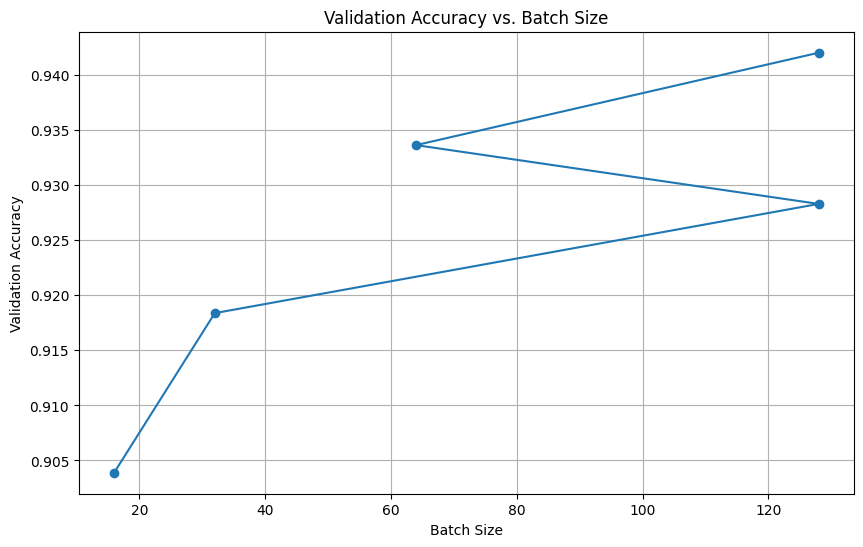

In [ ]:
# Define hyperparameters and scores
lstm_units = [256, 64, 192, 160, 256]
batch_size = [128, 64, 128, 32, 16]
val_accuracy = [0.9420289993286133, 0.9336384534835815, 0.9282990097999573, 0.9183829426765442, 0.9038901329040527]

# Plot the search results
plt.figure(figsize=(10, 6))

plt.plot(batch_size, val_accuracy, marker='o', linestyle='-')
plt.title('Validation Accuracy vs. Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

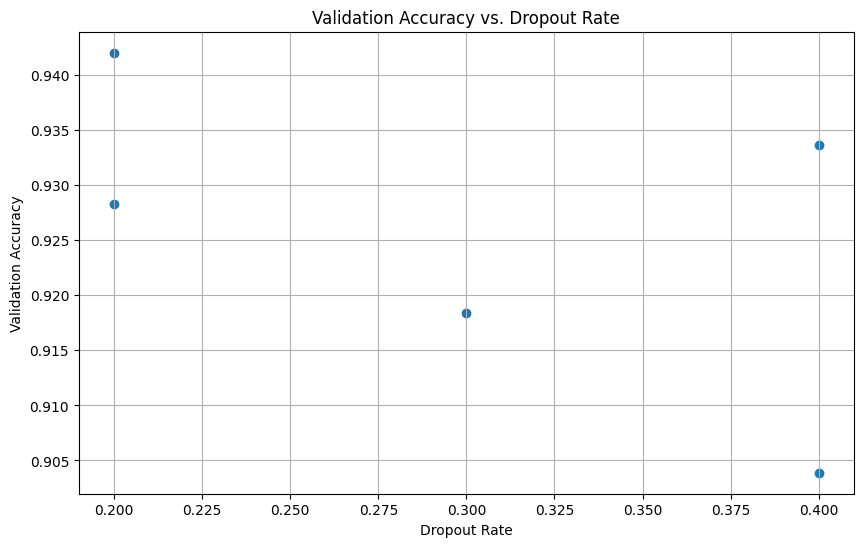

In [ ]:
import matplotlib.pyplot as plt

# Extract dropout rates and validation accuracies from tuner history
dropout_rates = [0.2, 0.4, 0.2, 0.30000000000000004, 0.4]  # Assuming these are the dropout rates for each trial
val_accuracies = [0.9420289993286133, 0.9336384534835815, 0.9282990097999573, 0.9183829426765442, 0.9038901329040527]  # Assuming these are the validation accuracies for each trial

# Plot accuracy vs dropout rate
plt.figure(figsize=(10, 6))
plt.scatter(dropout_rates, val_accuracies)
plt.title('Validation Accuracy vs. Dropout Rate')
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()


In [ ]:
# Access the best value obtained during the tuning process
best_value = tuner.oracle.get_best_trials(1)[0].score

print("Best value:", best_value)


Best value: 0.9420289993286133


In [ ]:
# Access the best trial from the tuner's oracle
best_trial = tuner.oracle.get_best_trials(1)[0]

# Print a summary of the best trial
print("Best Trial Summary:")
print("Hyperparameters:")
for param, value in best_trial.hyperparameters.values.items():
    print(f"{param}: {value}")
print("Score:", best_trial.score)


Best Trial Summary:
Hyperparameters:
lstm_units: 256
batch_size: 128
kernel1: 3
kernel2: 3
num_heads: 4
kernel3: 3
kernel4: 5
dropout1: 0.2
optimizer: sgd
learning_rate_adam: 0.001
learning_rate_rmsprop: 0.0001
learning_rate_sgd: 0.001
Score: 0.9420289993286133


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [ ]:
best_trial = tuner.oracle.get_best_trials(1)[0]
best_hyperparameters = best_trial.hyperparameters
best_model = build_model(best_hyperparameters)

# Train the best model
history = best_model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=30,
    validation_data=valid_gen,
    validation_steps=len(valid_gen),
    callbacks=[early_stopping]
)

Epoch 1/30
357/357 [==============================] - 116s 319ms/step - loss: 0.0901 - accuracy: 0.9653 - val_loss: 0.1795 - val_accuracy: 0.9214
Epoch 2/30
357/357 [==============================] - 109s 304ms/step - loss: 0.0808 - accuracy: 0.9702 - val_loss: 0.1754 - val_accuracy: 0.9336
Epoch 3/30
357/357 [==============================] - 104s 292ms/step - loss: 0.0759 - accuracy: 0.9730 - val_loss: 0.1733 - val_accuracy: 0.9329
Epoch 4/30
357/357 [==============================] - 103s 288ms/step - loss: 0.0737 - accuracy: 0.9741 - val_loss: 0.1718 - val_accuracy: 0.9336
Epoch 5/30
357/357 [==============================] - 103s 288ms/step - loss: 0.0710 - accuracy: 0.9748 - val_loss: 0.1692 - val_accuracy: 0.9367
Epoch 6/30
357/357 [==============================] - 103s 288ms/step - loss: 0.0694 - accuracy: 0.9750 - val_loss: 0.1677 - val_accuracy: 0.9367
Epoch 7/30
357/357 [==============================] - 102s 287ms/step - loss: 0.0675 - accuracy: 0.9767 - val_loss: 0.1699 -